In [1]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2DTranspose
import sys

import numpy as np
from numpy import expand_dims
from os import makedirs

170508288/170498071 [==============================] - 2s 0us/step
Train: X=  (50000, 32, 32, 3)


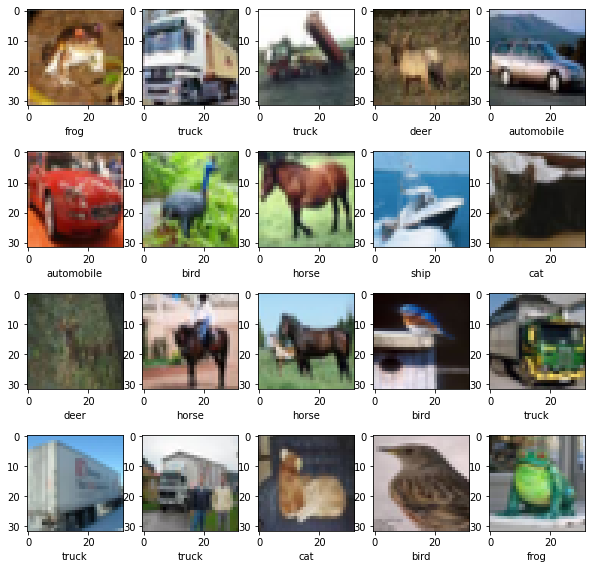

In [2]:
#import data
data=tf.keras.datasets.cifar10.load_data()
# load dataset
(X_train, y_train), (_,_) = data
print('Train: X= ' , (X_train.shape))

#obtained from tensorflow website, labels of the y class
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.figure(figsize=(10,10))
for i in range(20):
    # define subplot
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[i])
    plt.xlabel(labelNames[int(y_train[i])])
plt.show()

# Data Cleaning

In [3]:
# load dataset
(X_train, y_train), (_,_) = data
X_data=X_train.astype('float32')
X_data= (X_data - 127.5) / 127.5

# DCGAN Base Code

In [4]:
def define_generator(latent_dim):
    n_nodes = 256 * 4 * 4
    
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.18))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.18))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.18))
    
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [5]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [6]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [7]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(lr=0.0001, beta_1=0.3)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [9]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.00022, beta_1=0.48)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [10]:
def summarize_performance(step, g_model, latent_dim, name, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(10 * 10):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i])
    plt.savefig(f'./{name}/generated_plot_{step+1}.png')
    plt.close()
    g_model.save(f'./{name}/model_{step+1}.h5')

In [11]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, name):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.ylim(0, 2)
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # save plot to file
    plt.savefig(f'./{name}/plot_line_plot_loss.png')
    plt.close()

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, name, n_epochs=150, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            #train discriminator
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            
            # generate image examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            
            #train generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize and save loss
            if (j+1) % 30 == 0:
                print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
                (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
                d1_hist.append(d_loss1)
                d2_hist.append(d_loss2)
                g_hist.append(g_loss)
                a1_hist.append(d_acc1)
                a2_hist.append(d_acc2)
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, latent_dim, name)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, name)

In [13]:
latent_dim = 100
d_model_Plane = define_discriminator()
g_model_Plane = define_generator(latent_dim)
gan_model_Plane = define_gan(g_model_Plane, d_model_Plane)

2022-02-12 10:04:46.959516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 10:04:47.050421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 10:04:47.051234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 10:04:47.052890: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Sharpening Code

In [14]:
import cv2
import numpy as np
# Defining the kernel of size 3x3
kernel = np.array([
  [0, -1, 0],
  [-1, 5, -1],
  [0, -1, 0]
])
def sharped(input):
    output=[]
    for i in input:
        resulting_image = cv2.filter2D(i, -1, kernel)
        output.append(i)
    return np.array(output)


# DCGAN on 4 vehicles (sharpened) (X_train_6)

In [16]:
%%time

makedirs('DCGANVehicle4Sharp', exist_ok=True)

X_train_6=X_data[((y_train == 0) | (y_train == 1) | (y_train == 8) | (y_train == 9)).reshape(50000,)]
X_train_6=sharped(X_train_6)
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_6, latent_dim, "DCGANVehicle4Sharp", n_epochs=200)

>1, d1=0.688, d2=0.669 g=0.808, a1=46, a2=65
>1, d1=0.734, d2=0.602 g=0.887, a1=37, a2=89
>1, d1=0.693, d2=0.644 g=0.863, a1=45, a2=76
>1, d1=0.711, d2=0.653 g=0.858, a1=46, a2=68
>1, d1=0.746, d2=0.630 g=0.815, a1=28, a2=82
>2, d1=0.702, d2=0.689 g=0.805, a1=48, a2=56
>2, d1=0.695, d2=0.693 g=0.790, a1=48, a2=56
>2, d1=0.629, d2=0.686 g=0.816, a1=62, a2=64
>2, d1=0.666, d2=0.658 g=0.830, a1=57, a2=65
>2, d1=0.705, d2=0.638 g=0.855, a1=32, a2=71
>3, d1=0.641, d2=0.691 g=0.783, a1=59, a2=60
>3, d1=0.651, d2=0.655 g=0.811, a1=48, a2=68
>3, d1=0.540, d2=0.708 g=0.824, a1=78, a2=62
>3, d1=0.626, d2=0.746 g=0.774, a1=56, a2=45
>3, d1=0.650, d2=0.632 g=0.867, a1=48, a2=71
>4, d1=0.722, d2=0.603 g=0.826, a1=37, a2=84
>4, d1=0.641, d2=0.682 g=0.835, a1=60, a2=57
>4, d1=0.735, d2=0.645 g=0.794, a1=31, a2=71
>4, d1=0.678, d2=0.698 g=0.790, a1=50, a2=59
>4, d1=0.643, d2=0.719 g=0.794, a1=53, a2=53
>5, d1=0.667, d2=0.698 g=0.782, a1=53, a2=64
>5, d1=0.741, d2=0.589 g=0.862, a1=31, a2=92
>5, d1=0.6

2022-02-12 10:14:31.341324: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, d1=0.745, d2=0.615 g=0.915, a1=42, a2=82
>9, d1=0.673, d2=0.669 g=0.784, a1=51, a2=68
>9, d1=0.668, d2=0.668 g=0.814, a1=53, a2=62
>9, d1=0.752, d2=0.603 g=0.828, a1=26, a2=92
>9, d1=0.679, d2=0.651 g=0.816, a1=46, a2=65
>10, d1=0.758, d2=0.599 g=0.845, a1=20, a2=84
>10, d1=0.658, d2=0.740 g=0.850, a1=45, a2=53
>10, d1=0.707, d2=0.692 g=0.819, a1=43, a2=50
>10, d1=0.698, d2=0.664 g=0.792, a1=54, a2=67
>10, d1=0.544, d2=0.695 g=0.859, a1=78, a2=64
>11, d1=0.694, d2=0.657 g=0.789, a1=37, a2=70
>11, d1=0.716, d2=0.608 g=0.856, a1=39, a2=84
>11, d1=0.644, d2=0.728 g=0.811, a1=53, a2=53
>11, d1=0.692, d2=0.696 g=0.805, a1=48, a2=59
>11, d1=0.644, d2=0.722 g=0.811, a1=57, a2=46
>12, d1=0.686, d2=0.645 g=0.779, a1=46, a2=84
>12, d1=0.681, d2=0.665 g=0.853, a1=46, a2=67
>12, d1=0.678, d2=0.666 g=0.832, a1=51, a2=60
>12, d1=0.701, d2=0.639 g=0.805, a1=40, a2=78


2022-02-12 10:15:37.734329: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:15:37.807566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:15:37.972576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.686, d2=0.688 g=0.769, a1=46, a2=56
>13, d1=0.660, d2=0.674 g=0.781, a1=53, a2=64
>13, d1=0.686, d2=0.728 g=0.787, a1=43, a2=68
>13, d1=0.699, d2=0.724 g=0.820, a1=45, a2=54
>13, d1=0.620, d2=0.788 g=0.771, a1=59, a2=45
>13, d1=0.655, d2=0.672 g=0.766, a1=51, a2=62
>14, d1=0.709, d2=0.645 g=0.776, a1=39, a2=76
>14, d1=0.609, d2=0.704 g=0.806, a1=60, a2=65
>14, d1=0.704, d2=0.618 g=0.800, a1=34, a2=81
>14, d1=0.651, d2=0.655 g=0.812, a1=54, a2=71
>14, d1=0.709, d2=0.650 g=0.790, a1=35, a2=76
>15, d1=0.690, d2=0.652 g=0.800, a1=39, a2=79
>15, d1=0.664, d2=0.693 g=0.799, a1=45, a2=64
>15, d1=0.683, d2=0.672 g=0.809, a1=43, a2=67
>15, d1=0.709, d2=0.655 g=0.799, a1=42, a2=75
>15, d1=0.662, d2=0.626 g=0.768, a1=59, a2=84
>16, d1=0.655, d2=0.664 g=0.787, a1=56, a2=71
>16, d1=0.684, d2=0.704 g=0.825, a1=48, a2=54
>16, d1=0.693, d2=0.685 g=0.822, a1=45, a2=73
>16, d1=0.639, d2=0.674 g=0.792, a1=62, a2=68


2022-02-12 10:16:43.403327: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.669, d2=0.633 g=0.809, a1=53, a2=75
>17, d1=0.745, d2=0.680 g=0.854, a1=35, a2=71
>17, d1=0.659, d2=0.678 g=0.788, a1=53, a2=60
>17, d1=0.598, d2=0.693 g=0.793, a1=59, a2=70
>17, d1=0.679, d2=0.681 g=0.802, a1=54, a2=73
>17, d1=0.689, d2=0.731 g=0.885, a1=48, a2=57
>18, d1=0.654, d2=0.656 g=0.791, a1=54, a2=68
>18, d1=0.687, d2=0.660 g=0.783, a1=54, a2=64
>18, d1=0.670, d2=0.639 g=0.816, a1=50, a2=76
>18, d1=0.645, d2=0.691 g=0.787, a1=56, a2=65


2022-02-12 10:17:16.468107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.646, d2=0.665 g=0.831, a1=57, a2=70
>19, d1=0.694, d2=0.653 g=0.826, a1=42, a2=75
>19, d1=0.712, d2=0.640 g=0.831, a1=29, a2=70
>19, d1=0.692, d2=0.622 g=0.821, a1=48, a2=78
>19, d1=0.693, d2=0.674 g=0.803, a1=43, a2=65
>19, d1=0.684, d2=0.663 g=0.852, a1=48, a2=65
>20, d1=0.626, d2=0.726 g=0.801, a1=56, a2=56
>20, d1=0.670, d2=0.644 g=0.809, a1=50, a2=73
>20, d1=0.708, d2=0.634 g=0.831, a1=42, a2=76
>20, d1=0.650, d2=0.673 g=0.828, a1=50, a2=64
>20, d1=0.690, d2=0.642 g=0.802, a1=37, a2=76
>21, d1=0.677, d2=0.646 g=0.829, a1=43, a2=73
>21, d1=0.644, d2=0.754 g=0.832, a1=59, a2=48
>21, d1=0.661, d2=0.667 g=0.826, a1=43, a2=65
>21, d1=0.654, d2=0.679 g=0.792, a1=53, a2=60
>21, d1=0.725, d2=0.674 g=0.792, a1=39, a2=60
>22, d1=0.727, d2=0.651 g=0.795, a1=37, a2=73
>22, d1=0.644, d2=0.699 g=0.809, a1=53, a2=57
>22, d1=0.637, d2=0.648 g=0.785, a1=57, a2=73


2022-02-12 10:18:22.554115: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.722, d2=0.678 g=0.819, a1=42, a2=67
>22, d1=0.716, d2=0.625 g=0.806, a1=40, a2=79
>23, d1=0.642, d2=0.655 g=0.809, a1=48, a2=67
>23, d1=0.615, d2=0.716 g=0.826, a1=50, a2=64
>23, d1=0.682, d2=0.676 g=0.830, a1=46, a2=62
>23, d1=0.681, d2=0.637 g=0.810, a1=45, a2=79
>23, d1=0.624, d2=0.768 g=0.832, a1=60, a2=39
>24, d1=0.687, d2=0.636 g=0.835, a1=45, a2=75
>24, d1=0.666, d2=0.683 g=0.826, a1=50, a2=71
>24, d1=0.684, d2=0.681 g=0.802, a1=46, a2=64
>24, d1=0.692, d2=0.630 g=0.815, a1=48, a2=76
>24, d1=0.593, d2=0.685 g=0.807, a1=70, a2=62
>25, d1=0.686, d2=0.682 g=0.805, a1=43, a2=70
>25, d1=0.659, d2=0.721 g=0.808, a1=50, a2=48
>25, d1=0.620, d2=0.672 g=0.802, a1=59, a2=70
>25, d1=0.653, d2=0.654 g=0.794, a1=51, a2=70
>25, d1=0.610, d2=0.669 g=0.785, a1=62, a2=71
>26, d1=0.701, d2=0.642 g=0.835, a1=46, a2=71
>26, d1=0.647, d2=0.623 g=0.819, a1=54, a2=75
>26, d1=0.684, d2=0.665 g=0.870, a1=40, a2=71
>26, d1=0.607, d2=0.649 g=0.788, a1=53, a2=76
>26, d1=0.693, d2=0.659 g=0.806, a

2022-02-12 10:20:34.463322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.619, d2=0.689 g=0.814, a1=53, a2=71
>30, d1=0.666, d2=0.656 g=0.803, a1=50, a2=75
>31, d1=0.696, d2=0.655 g=0.820, a1=46, a2=64
>31, d1=0.612, d2=0.686 g=0.837, a1=50, a2=60
>31, d1=0.705, d2=0.634 g=0.802, a1=43, a2=84
>31, d1=0.650, d2=0.634 g=0.816, a1=54, a2=75
>31, d1=0.665, d2=0.700 g=0.823, a1=48, a2=56
>32, d1=0.580, d2=0.639 g=0.853, a1=59, a2=75
>32, d1=0.650, d2=0.644 g=0.791, a1=53, a2=71
>32, d1=0.664, d2=0.646 g=0.834, a1=48, a2=73
>32, d1=0.685, d2=0.615 g=0.838, a1=48, a2=75
>32, d1=0.669, d2=0.625 g=0.839, a1=50, a2=82
>33, d1=0.719, d2=0.606 g=0.845, a1=37, a2=84
>33, d1=0.588, d2=0.665 g=0.817, a1=65, a2=67
>33, d1=0.665, d2=0.701 g=0.874, a1=48, a2=54
>33, d1=0.629, d2=0.650 g=0.807, a1=51, a2=65
>33, d1=0.688, d2=0.644 g=0.881, a1=43, a2=73
>34, d1=0.675, d2=0.656 g=0.823, a1=48, a2=67
>34, d1=0.617, d2=0.622 g=0.819, a1=57, a2=78
>34, d1=0.639, d2=0.608 g=0.816, a1=56, a2=81
>34, d1=0.652, d2=0.610 g=0.834, a1=54, a2=82
>34, d1=0.651, d2=0.709 g=0.842, a

2022-02-12 10:29:44.136336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>63, d1=0.595, d2=0.621 g=0.902, a1=64, a2=78
>63, d1=0.651, d2=0.601 g=0.959, a1=53, a2=79
>63, d1=0.588, d2=0.650 g=0.913, a1=67, a2=67
>64, d1=0.590, d2=0.676 g=0.962, a1=54, a2=64
>64, d1=0.637, d2=0.587 g=0.903, a1=48, a2=84
>64, d1=0.575, d2=0.598 g=0.937, a1=57, a2=70
>64, d1=0.669, d2=0.665 g=0.867, a1=56, a2=67
>64, d1=0.652, d2=0.692 g=0.979, a1=56, a2=65
>65, d1=0.580, d2=0.603 g=0.952, a1=62, a2=79
>65, d1=0.654, d2=0.626 g=0.898, a1=51, a2=73
>65, d1=0.656, d2=0.658 g=0.962, a1=51, a2=76
>65, d1=0.575, d2=0.657 g=0.888, a1=62, a2=68
>65, d1=0.697, d2=0.598 g=0.931, a1=51, a2=78
>66, d1=0.645, d2=0.678 g=0.926, a1=54, a2=65
>66, d1=0.655, d2=0.621 g=0.863, a1=51, a2=73
>66, d1=0.602, d2=0.650 g=0.931, a1=59, a2=68
>66, d1=0.617, d2=0.619 g=0.929, a1=54, a2=75
>66, d1=0.686, d2=0.568 g=0.940, a1=45, a2=81
>67, d1=0.678, d2=0.620 g=0.973, a1=54, a2=68
>67, d1=0.568, d2=0.642 g=0.939, a1=67, a2=71
>67, d1=0.659, d2=0.638 g=0.953, a1=50, a2=70
>67, d1=0.592, d2=0.634 g=0.984, a

2022-02-12 10:38:10.565794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>93, d1=0.540, d2=0.541 g=1.103, a1=64, a2=78
>93, d1=0.606, d2=0.434 g=1.270, a1=57, a2=89
>94, d1=0.565, d2=0.505 g=1.156, a1=70, a2=79
>94, d1=0.534, d2=0.549 g=1.125, a1=67, a2=78
>94, d1=0.555, d2=0.576 g=1.140, a1=67, a2=67
>94, d1=0.609, d2=0.504 g=1.072, a1=57, a2=82
>94, d1=0.612, d2=0.619 g=1.149, a1=56, a2=78
>95, d1=0.600, d2=0.579 g=1.176, a1=59, a2=75
>95, d1=0.566, d2=0.532 g=1.195, a1=65, a2=73
>95, d1=0.638, d2=0.480 g=1.167, a1=56, a2=85
>95, d1=0.638, d2=0.544 g=1.082, a1=59, a2=79
>95, d1=0.540, d2=0.564 g=1.209, a1=70, a2=75
>96, d1=0.639, d2=0.537 g=1.187, a1=54, a2=79
>96, d1=0.551, d2=0.558 g=1.159, a1=62, a2=78
>96, d1=0.633, d2=0.514 g=1.142, a1=53, a2=79
>96, d1=0.603, d2=0.549 g=1.097, a1=64, a2=75
>96, d1=0.664, d2=0.534 g=1.131, a1=57, a2=79
>97, d1=0.572, d2=0.575 g=1.182, a1=59, a2=75
>97, d1=0.457, d2=0.541 g=1.155, a1=70, a2=76
>97, d1=0.625, d2=0.494 g=1.139, a1=62, a2=76
>97, d1=0.660, d2=0.503 g=1.286, a1=57, a2=79
>97, d1=0.572, d2=0.617 g=1.216, a

2022-02-12 10:40:11.257999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>100, d1=0.549, d2=0.523 g=1.212, a1=64, a2=78
>101, d1=0.567, d2=0.615 g=1.114, a1=62, a2=73
>101, d1=0.524, d2=0.531 g=1.236, a1=71, a2=75
>101, d1=0.625, d2=0.491 g=1.129, a1=53, a2=82
>101, d1=0.559, d2=0.503 g=1.181, a1=71, a2=78
>101, d1=0.569, d2=0.594 g=1.313, a1=64, a2=71
>102, d1=0.571, d2=0.509 g=1.239, a1=57, a2=79
>102, d1=0.605, d2=0.572 g=1.298, a1=59, a2=73
>102, d1=0.539, d2=0.473 g=1.378, a1=65, a2=84
>102, d1=0.453, d2=0.571 g=1.178, a1=70, a2=75
>102, d1=0.606, d2=0.487 g=1.205, a1=64, a2=76
>103, d1=0.587, d2=0.538 g=1.181, a1=60, a2=82
>103, d1=0.537, d2=0.552 g=1.242, a1=67, a2=78
>103, d1=0.514, d2=0.522 g=1.244, a1=68, a2=81
>103, d1=0.551, d2=0.593 g=1.223, a1=67, a2=78
>103, d1=0.561, d2=0.507 g=1.155, a1=62, a2=82
>104, d1=0.612, d2=0.523 g=1.300, a1=53, a2=75
>104, d1=0.610, d2=0.595 g=1.252, a1=60, a2=75
>104, d1=0.444, d2=0.564 g=1.226, a1=70, a2=73
>104, d1=0.537, d2=0.446 g=1.267, a1=70, a2=84
>104, d1=0.514, d2=0.580 g=1.246, a1=73, a2=82
>105, d1=0.56

2022-02-12 10:54:40.051028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>152, d1=0.463, d2=0.326 g=1.942, a1=71, a2=89
>153, d1=0.409, d2=0.336 g=1.804, a1=76, a2=90
>153, d1=0.363, d2=0.268 g=1.903, a1=78, a2=95
>153, d1=0.453, d2=0.463 g=2.094, a1=78, a2=85
>153, d1=0.349, d2=0.312 g=1.979, a1=82, a2=90
>153, d1=0.404, d2=0.299 g=2.109, a1=81, a2=87
>154, d1=0.363, d2=0.354 g=2.081, a1=79, a2=85
>154, d1=0.355, d2=0.318 g=2.056, a1=82, a2=85
>154, d1=0.290, d2=0.299 g=2.324, a1=89, a2=85
>154, d1=0.358, d2=0.656 g=2.010, a1=81, a2=75
>154, d1=0.324, d2=0.276 g=2.074, a1=82, a2=90
>155, d1=0.355, d2=0.333 g=1.946, a1=81, a2=89
>155, d1=0.408, d2=0.370 g=1.964, a1=78, a2=85
>155, d1=0.315, d2=0.377 g=1.936, a1=84, a2=84
>155, d1=0.411, d2=0.271 g=1.942, a1=78, a2=89
>155, d1=0.366, d2=0.595 g=2.086, a1=81, a2=75
>156, d1=0.500, d2=0.406 g=1.896, a1=73, a2=81
>156, d1=0.330, d2=0.360 g=1.891, a1=81, a2=87
>156, d1=0.374, d2=0.445 g=2.028, a1=81, a2=85
>156, d1=0.386, d2=0.380 g=2.096, a1=82, a2=92
>156, d1=0.430, d2=0.267 g=2.078, a1=75, a2=89
>157, d1=0.29

2022-02-12 10:59:26.185017: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>170, d1=0.321, d2=0.334 g=2.194, a1=82, a2=87
>170, d1=0.273, d2=0.348 g=2.323, a1=87, a2=87
>170, d1=0.294, d2=0.276 g=2.205, a1=87, a2=89
>170, d1=0.361, d2=0.259 g=2.285, a1=75, a2=92
>170, d1=0.488, d2=0.317 g=2.058, a1=70, a2=89
>171, d1=0.375, d2=0.292 g=2.250, a1=79, a2=90
>171, d1=0.374, d2=0.490 g=2.243, a1=79, a2=79
>171, d1=0.301, d2=0.374 g=2.537, a1=81, a2=89
>171, d1=0.287, d2=0.345 g=2.260, a1=87, a2=85
>171, d1=0.462, d2=0.302 g=2.443, a1=75, a2=90
>172, d1=0.279, d2=0.314 g=2.197, a1=89, a2=92
>172, d1=0.288, d2=0.632 g=2.378, a1=89, a2=76
>172, d1=0.459, d2=0.270 g=2.330, a1=75, a2=89
>172, d1=0.289, d2=0.295 g=2.462, a1=85, a2=90
>172, d1=0.372, d2=0.382 g=2.303, a1=82, a2=85
>173, d1=0.450, d2=0.270 g=2.202, a1=73, a2=89
>173, d1=0.332, d2=0.301 g=2.301, a1=84, a2=90
>173, d1=0.333, d2=0.329 g=2.320, a1=82, a2=82
>173, d1=0.333, d2=0.539 g=2.050, a1=79, a2=81
>173, d1=0.396, d2=0.334 g=2.502, a1=81, a2=89
>174, d1=0.351, d2=0.264 g=2.382, a1=82, a2=93
>174, d1=0.31

2022-02-12 11:00:43.099313: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:00:43.313138: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>174, d1=0.419, d2=0.405 g=2.508, a1=82, a2=84
>174, d1=0.326, d2=0.488 g=2.458, a1=82, a2=78
>175, d1=0.305, d2=0.393 g=2.446, a1=85, a2=87
>175, d1=0.306, d2=0.390 g=2.454, a1=84, a2=84
>175, d1=0.364, d2=0.304 g=2.487, a1=85, a2=85
>175, d1=0.230, d2=0.271 g=2.396, a1=93, a2=90
>175, d1=0.355, d2=0.372 g=2.506, a1=82, a2=87
>176, d1=0.284, d2=0.278 g=2.497, a1=89, a2=90
>176, d1=0.276, d2=0.338 g=2.457, a1=87, a2=84
>176, d1=0.292, d2=0.385 g=2.420, a1=85, a2=82
>176, d1=0.249, d2=0.421 g=2.356, a1=89, a2=79
>176, d1=0.451, d2=0.556 g=2.666, a1=78, a2=75
>180, d1=0.280, d2=0.297 g=2.402, a1=85, a2=87
>180, d1=0.225, d2=0.223 g=2.419, a1=90, a2=90
>180, d1=0.349, d2=0.287 g=2.547, a1=78, a2=87
>180, d1=0.293, d2=0.262 g=2.478, a1=81, a2=90
>181, d1=0.274, d2=0.294 g=2.394, a1=89, a2=87
>181, d1=0.438, d2=0.323 g=2.469, a1=75, a2=89
>181, d1=0.318, d2=0.375 g=2.619, a1=82, a2=82
>181, d1=0.331, d2=0.233 g=2.778, a1=89, a2=89
>181, d1=0.389, d2=0.307 g=2.498, a1=76, a2=87
>182, d1=0.37

2022-02-12 11:07:41.166021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>199, d1=0.215, d2=0.222 g=3.199, a1=90, a2=93
>199, d1=0.230, d2=0.225 g=3.003, a1=89, a2=92
>200, d1=0.245, d2=0.591 g=3.430, a1=89, a2=79
>200, d1=0.244, d2=0.202 g=3.119, a1=90, a2=93
>200, d1=0.239, d2=0.377 g=2.883, a1=90, a2=85
>200, d1=0.314, d2=0.499 g=3.427, a1=84, a2=84
>200, d1=0.340, d2=0.225 g=3.044, a1=81, a2=93
CPU times: user 38min 2s, sys: 1min 56s, total: 39min 59s
Wall time: 55min 52s
